In [217]:
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.cluster import KMeans #import k-means clustering
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist, pdist

In [273]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

def get_elbow_scores(data, max_num, min_num=1):
    avgs = pd.DataFrame(columns=['cluster_num', 'score'])

    for n in range(min_num,max_num+1):
        km_elbow = KMeans(n_clusters=n).fit(data) 
        centroids = [km_elbow.cluster_centers_]
        Dists_k = [cdist(data, cent, 'euclidean') for cent in centroids]

        dist = [np.min(D,axis=1) for D in Dists_k]
        avg = [sum(d)/data.shape[0] for d in dist]
        avgs = avgs.append({'cluster_num': n, 'score': avg[0]}, ignore_index=True)
    return avgs

def get_kmeans_labels(data, num_clusters):
    km = KMeans(n_clusters=num_clusters) 
    results=km.fit(data) 
    return results.labels_

def massage_original_data(data):
    data = data.sort_values(by=['price'])
    data = data[data['price'] != 'MISSING'] ## NOTE: filters out MISSING prices 
    data['price_cat'] = pd.factorize(data['price'])[0]+1
    ## $= under $10. $$=11-30. $$$=31-60. $$$$= over $61.
    data.loc[data['price'] == '$', 'price'] = 10
    data.loc[data['price'] == '$$', 'price'] = 20
    data.loc[data['price'] == '$$$', 'price'] = 45
    data.loc[data['price'] == '$$$$', 'price'] = 65
    return data

def normalize_data(data):
    data['review_cou']=(data['review_cou']-data['review_cou'].mean())/data['review_cou'].std()
    data['price_cat']=(data['price_cat']-data['price_cat'].mean())/data['price_cat'].std()
    return data

def do_elbow(data, columns, name, ticks=15):
    data_sub = data[columns].copy()
    data_std = normalize_data(data_sub)
    scores = get_elbow_scores(data_std, ticks)
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title("Elbow Scores: {}".format(name), fontsize=18)
    ax.set_xlabel("Cluster Number")
    ax.set_ylabel("Avg Within SS")
    ax.plot(scores.cluster_num, scores.score,'r-') 
    
def do_kmeans(data, num_clusters, cols_analysis):
    data_sub = data[columns].copy()
    data_std = normalize_data(data_sub)
    labels = get_kmeans_labels(data_std, num_clusters)
    data['cluster'] = labels

    f, ax = plt.subplots(figsize=(10, 10))
    data.plot(ax=ax, column='cluster', legend=True)

    stats = data[cols_analysis].groupby(['cluster'], as_index=False).mean()
    stats['cluster'] = stats.index
    #print(min_max_scaler.fit_transform(stats['review_cou'].values.reshape(-1, 1)).reshape(1, -1)[0])
    stats['review_cou']= min_max_scaler.fit_transform(stats['review_cou'].values.reshape(-1, 1)).reshape(1, -1)[0] #(stats['review_cou']-stats['review_cou'].mean())/stats['review_cou'].std()
    stats['rating']= min_max_scaler.fit_transform(stats['rating'].values.reshape(-1, 1)).reshape(1, -1)[0] #(stats['rating']-stats['rating'].mean())/stats['rating'].std()
    stats['price']= min_max_scaler.fit_transform(stats['price'].values.reshape(-1, 1)).reshape(1, -1)[0]#(stats['price']-stats['price'].mean())/stats['price'].std()
    stats['weight'] = stats['review_cou'] * stats['rating'] * stats['price']
    data = pd.merge(data, stats[['cluster','weight']], on='cluster', how='left')
    return data

def avg_clusters_by_NTA(data, NTA):
    temp = data[['weight','NTACode']].groupby(['NTACode'], as_index=False).mean()
    temp = temp.rename(columns={'weight': 'avg_weight'})
    temp = pd.merge(data, temp, on='NTACode', how='left')
#     f, ax = plt.subplots(1, figsize=(12, 12))
#     temp.plot(ax=ax, column='avg_cluster', legend=True)
    data_nta = pd.merge(temp, NTA, on='NTACode', how='left')
    data_nta['geometry'] = data_nta['geometry_y']
    return data_nta

def plot_map(data):
    f, ax = plt.subplots(1, figsize=(12, 12))
    data.plot(ax=ax, column='avg_weight', legend=True ) # , cmap='Pastel1')

In [252]:
# data paths
data_path = "./data"
Yelp_BK_path = data_path +  "/Yelp/BK/"
Yelp_MN_path = data_path + "/Yelp/MN/"
path_census_tracts = './data/ACS/CensusTracts'

In [220]:
columns = ['review_cou','rating', 'price_cat']
cols_analysis = ['cluster','review_cou','rating','price']

In [221]:
# Reading in Yelp shapefiles 
MN_Yelp = gpd.read_file(Yelp_MN_path + "MN_Yelp_CensusTract_NTA.shp")
BK_Yelp = gpd.read_file(Yelp_BK_path + "BK_Yelp_CensusTract_NTA.shp")

NY_Yelp = MN_Yelp.append([BK_Yelp], sort='True')
NTA = gpd.read_file('data/NTA/nynta.shp')

MN_Yelp = massage_original_data(MN_Yelp)
BK_Yelp = massage_original_data(BK_Yelp)
NY_Yelp = massage_original_data(NY_Yelp)

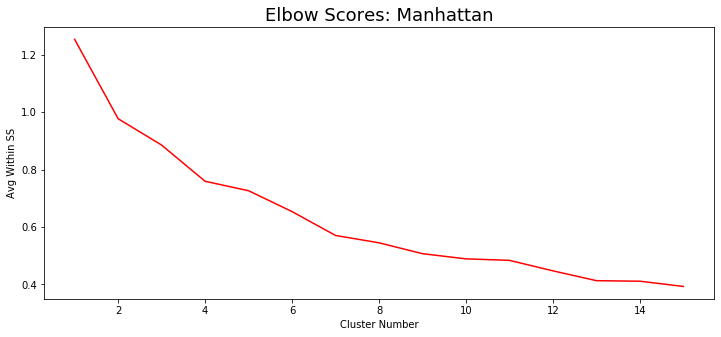

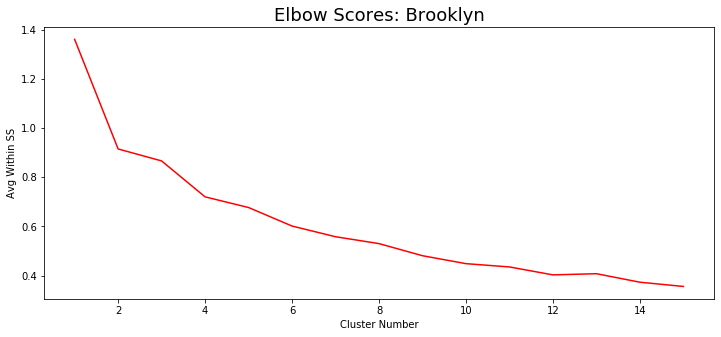

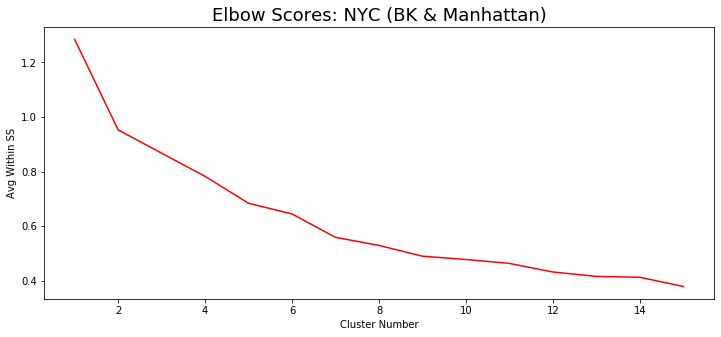

In [222]:
do_elbow(MN_Yelp, columns, 'Manhattan')

do_elbow(BK_Yelp, columns, 'Brooklyn')

do_elbow(NY_Yelp, columns, 'NYC (BK & Manhattan)')

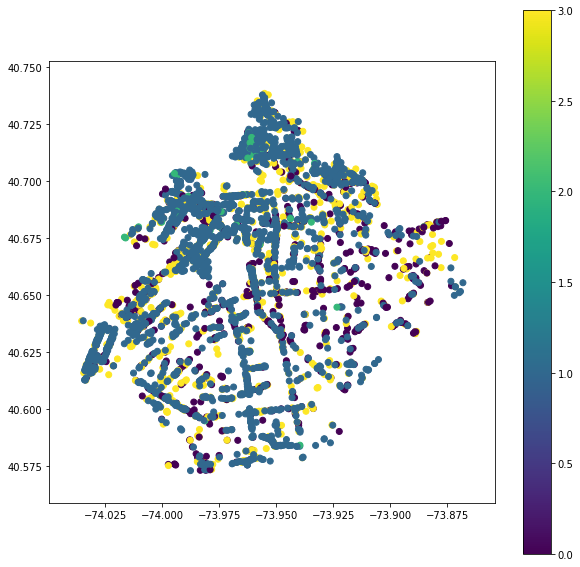

In [274]:
BK_Yelp_clustered = do_kmeans(BK_Yelp, 4, cols_analysis)

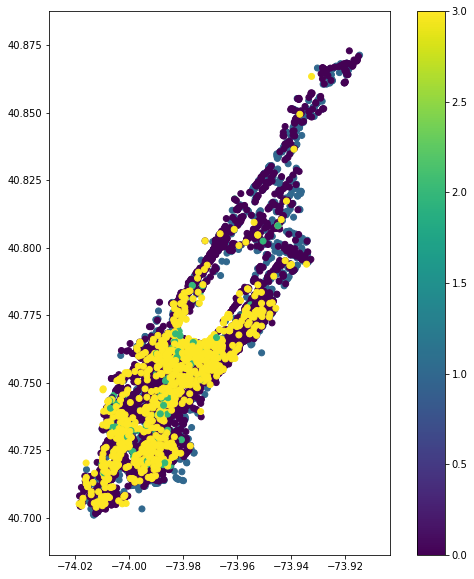

In [275]:
MN_Yelp_clustered = do_kmeans(MN_Yelp, 4, cols_analysis)

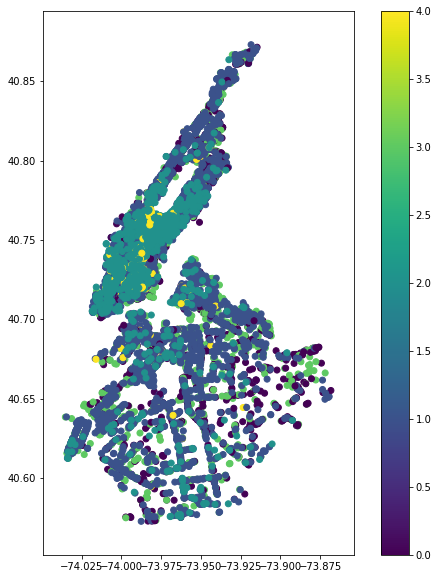

In [276]:
NY_Yelp_clustered = do_kmeans(NY_Yelp, 5, cols_analysis)

In [277]:
NY_NTA_Yelp = avg_clusters_by_NTA(NY_Yelp_clustered, NTA)
BK_NTA_Yelp = avg_clusters_by_NTA(BK_Yelp_clustered, NTA)
MN_NTA_Yelp = avg_clusters_by_NTA(MN_Yelp_clustered, NTA)

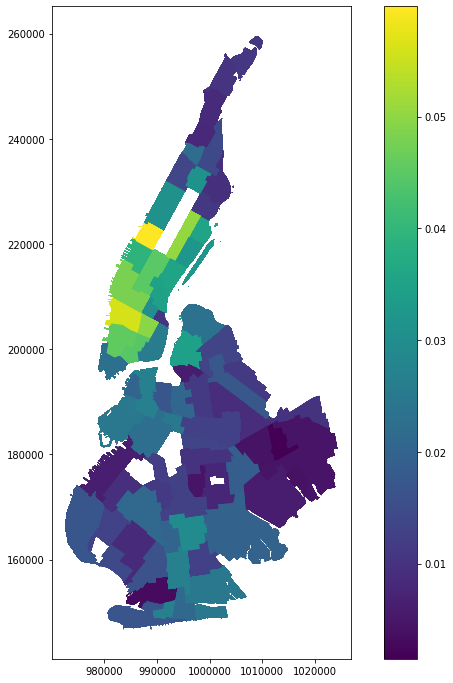

In [278]:
plot_map(NY_NTA_Yelp)

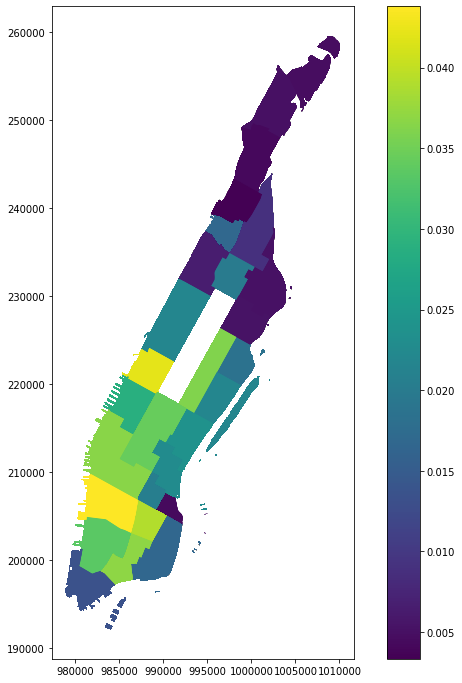

In [279]:
plot_map(MN_NTA_Yelp)

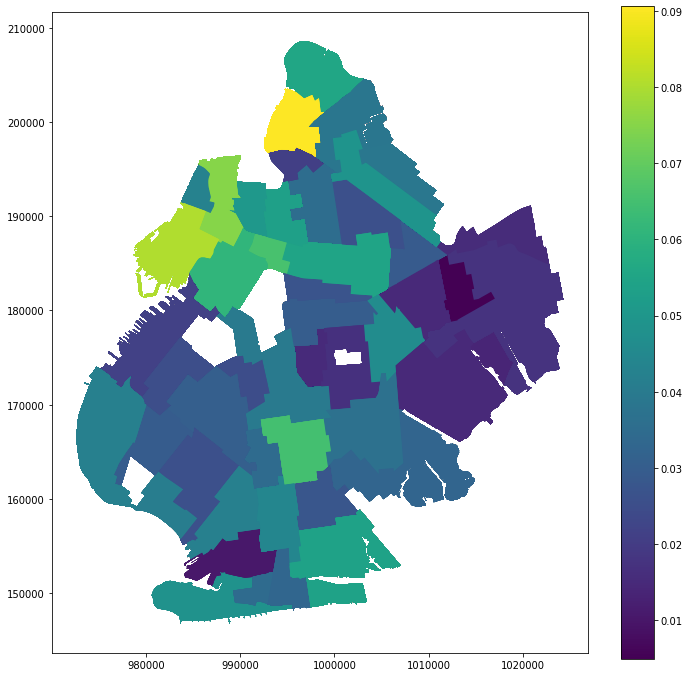

In [280]:
plot_map(BK_NTA_Yelp)